In [59]:
library(lmerTest)
library(MuMIn)
library(VIF)
library(sqldf)
library(car)
library(ggplot2)
library(sjPlot)
library(sjmisc)
library(sjlabelled)
library(ggeffects)


filename <- 'generated/num_of_review_comments.csv'

effectiveCommentsData <- read.csv(file=filename, header=TRUE, sep=",")

effectiveCommentsData$LanguageType = as.factor(effectiveCommentsData$LanguageType)

effectiveCommentsData$EffectiveComments = log(effectiveCommentsData$EffectiveComments + 1)
effectiveCommentsData$Additions = log(effectiveCommentsData$Additions + 1)
effectiveCommentsData$Deletions = log(effectiveCommentsData$Deletions + 1)
effectiveCommentsData$TotalReviewComments = log(effectiveCommentsData$TotalReviewComments + 1)
effectiveCommentsData$TotalReviewCommentThreads = log(effectiveCommentsData$TotalReviewCommentThreads + 1)
effectiveCommentsData$GeneralComments = log(effectiveCommentsData$GeneralComments + 1)
effectiveCommentsData$Commits = log(effectiveCommentsData$Commits + 1)
effectiveCommentsData$Assignees = log(effectiveCommentsData$Assignees + 1)
effectiveCommentsData$ChangedFiles = log(effectiveCommentsData$ChangedFiles + 1)
effectiveCommentsData$PrOpenedDaysAfterProjectStart = log(effectiveCommentsData$PrOpenedDaysAfterProjectStart + 1)
effectiveCommentsData$NumOfUniqueUsers = log(effectiveCommentsData$NumOfUniqueUsers + 1)
effectiveCommentsData$PRsOpened = log(effectiveCommentsData$PRsOpened + 1)
effectiveCommentsData$TotalBuilds = log(effectiveCommentsData$TotalBuilds + 1)
effectiveCommentsData$AdditionsAfterCreate = log(effectiveCommentsData$AdditionsAfterCreate + 1)
effectiveCommentsData$CommitsAfterCreate = log(effectiveCommentsData$CommitsAfterCreate + 1)
effectiveCommentsData$DeletionsAfterCreate = log(effectiveCommentsData$DeletionsAfterCreate + 1)

summary(effectiveCommentsData)

 EffectiveComments TotalReviewComments TotalReviewCommentThreads
 Min.   :0.00000   Min.   :0.0000      Min.   :0.0000           
 1st Qu.:0.00000   1st Qu.:0.0000      1st Qu.:0.0000           
 Median :0.00000   Median :0.0000      Median :0.0000           
 Mean   :0.07706   Mean   :0.3023      Mean   :0.2787           
 3rd Qu.:0.00000   3rd Qu.:0.0000      3rd Qu.:0.0000           
 Max.   :6.18826   Max.   :6.2046      Max.   :6.2005           
                                                                
 ShareReviewComments GeneralComments  GeneralCommentsDiscussingBuild
 Min.   :  0.00      Min.   :0.0000   Min.   :0                     
 1st Qu.:  0.00      1st Qu.:0.0000   1st Qu.:0                     
 Median :  0.00      Median :0.6931   Median :0                     
 Mean   : 10.45      Mean   :0.8909   Mean   :0                     
 3rd Qu.:  0.00      3rd Qu.:1.3863   3rd Qu.:0                     
 Max.   :100.00      Max.   :6.9431   Max.   :0                   

In [60]:
hasEffectiveComments <- sqldf("select *
                      from 'effectiveCommentsData' 
                      where EffectiveComments > 0")

print(nrow(hasEffectiveComments))

summary(hasEffectiveComments)

[1] 19318


 EffectiveComments TotalReviewComments TotalReviewCommentThreads
 Min.   :0.6931    Min.   :0.6931      Min.   :0.6931           
 1st Qu.:0.6931    1st Qu.:1.0986      1st Qu.:1.0986           
 Median :1.0986    Median :1.7918      Median :1.6094           
 Mean   :1.3036    Mean   :1.9354      Mean   :1.7922           
 3rd Qu.:1.6094    3rd Qu.:2.5649      3rd Qu.:2.3979           
 Max.   :6.1883    Max.   :6.2046      Max.   :6.2005           
                                                                
 ShareReviewComments GeneralComments GeneralCommentsDiscussingBuild
 Min.   :  0.9132    Min.   :0.000   Min.   :0                     
 1st Qu.: 36.3636    1st Qu.:1.099   1st Qu.:0                     
 Median : 60.0000    Median :1.609   Median :0                     
 Mean   : 58.3245    Mean   :1.629   Mean   :0                     
 3rd Qu.: 80.0000    3rd Qu.:2.197   3rd Qu.:0                     
 Max.   :100.0000    Max.   :5.635   Max.   :0                     
    

# Hurdle

First we make a hurdle model to determine whether we can detect zero pull requests vs non zero pull requests. We pick an equal amount of pull requests with zero and non zero effective comments and then build a linear regression. 

In [61]:
zerosdf <- sqldf('select * from "effectiveCommentsData" where EffectiveComments = 0')

sampledZerosdf <- zerosdf[sample(nrow(zerosdf), nrow(hasEffectiveComments)),]

combined <- rbind(sampledZerosdf, hasEffectiveComments)

hurdleModel = glm((EffectiveComments > 0) ~ 
            Additions + 
            Deletions +
            IsMerged +
            Commits + 
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            #TotalReviewComments + 
            TotalReviewCommentThreads +
            GeneralComments + 
            CommitsAfterCreate + 
            #AdditionsAfterCreate +
            #DeletionsAfterCreate +
            LanguageType +
            IsAfter ,
          data= combined,
                 family = 'binomial')
summary(hurdleModel)
r.squaredGLMM(hurdleModel)
vif(hurdleModel)
anova(hurdleModel)


Call:
glm(formula = (EffectiveComments > 0) ~ Additions + Deletions + 
    IsMerged + Commits + Assignees + ChangedFiles + NumOfUniqueUsers + 
    PRsOpened + TotalBuilds + NewContributor + PrOpenedDaysAfterProjectStart + 
    FromOutsider + TotalReviewCommentThreads + GeneralComments + 
    CommitsAfterCreate + LanguageType + IsAfter, family = "binomial", 
    data = combined)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-5.2974  -0.2093  -0.0040   0.2453   2.7407  

Coefficients:
                               Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   -4.738104   0.217836 -21.751  < 2e-16 ***
Additions                      0.002298   0.016881   0.136 0.891700    
Deletions                     -0.202255   0.016621 -12.168  < 2e-16 ***
IsMergedTrue                   0.512359   0.051294   9.989  < 2e-16 ***
Commits                       -0.790155   0.053568 -14.751  < 2e-16 ***
Assignees                      0.247503   0.098578   2.51

R2m       R2c 
0.8623988 0.8623988

,GVIF,Df,GVIF^(1/(2*Df))
Additions,3.101193,1,1.761021
Deletions,2.523651,1,1.588600
IsMerged,1.136081,1,1.065871
Commits,2.471701,1,1.572164
Assignees,1.024655,1,1.012253
ChangedFiles,3.495980,1,1.869754
NumOfUniqueUsers,2.624175,1,1.619931
PRsOpened,2.780220,1,1.667399
TotalBuilds,3.067156,1,1.751330
NewContributor,1.729723,1,1.315189


,Df,Deviance,Resid. Df,Resid. Dev
NULL,NA,NA,38635,53560.87
Additions,1,4.454611e+03,38634,49106.26
Deletions,1,2.877256e+02,38633,48818.53
IsMerged,1,2.909736e+01,38632,48789.43
Commits,1,8.378577e+03,38631,40410.86
Assignees,1,1.610671e+02,38630,40249.79
ChangedFiles,1,1.857284e+02,38629,40064.06
NumOfUniqueUsers,1,8.588961e+03,38628,31475.10
PRsOpened,1,4.998712e-02,38627,31475.05
TotalBuilds,1,5.661333e+02,38626,30908.92


In [62]:
executeLmOnData <- function(formula, data) {
    model = lm(formula ,
          data= data)
    print(summary(model))
    #r.squaredGLMM(model)
    print(vif(model))
    print(anova(model))
    
    return(model)
}

In [63]:
baseModel <- executeLmOnData(
            EffectiveComments ~ 
            Additions + 
            Deletions +
            IsMerged +
            #Commits + 
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            #TotalReviewComments + 
            TotalReviewCommentThreads +
            GeneralComments + 
            #CommitsAfterCreate + 
            #AdditionsAfterCreate +
            #DeletionsAfterCreate +
            IsAfter ,
        hasEffectiveComments)


Call:
lm(formula = formula, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.37657 -0.22593  0.04122  0.25917  2.05607 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    0.262222   0.035262   7.436 1.08e-13 ***
Additions                      0.023568   0.002513   9.378  < 2e-16 ***
Deletions                     -0.056612   0.002276 -24.871  < 2e-16 ***
IsMergedTrue                   0.011227   0.008179   1.373  0.16987    
Assignees                     -0.034662   0.013841  -2.504  0.01228 *  
ChangedFiles                   0.007003   0.005489   1.276  0.20199    
NumOfUniqueUsers              -0.058988   0.012288  -4.800 1.60e-06 ***
PRsOpened                     -0.008592   0.002743  -3.132  0.00174 ** 
TotalBuilds                    0.075184   0.005524  13.611  < 2e-16 ***
NewContributorTrue            -0.007506   0.011845  -0.634  0.52629    
PrOpenedDaysAfterProjectStart  0.007420   0.004

# Language type

This cell introduces language type (dynamic / static / unk) to the linear model. This shows a very small increase in the accuracy of the model.

Commits, additions and deletions after create are not included because of high vif scores. 

In [64]:
ltypeModel <- executeLmOnData(
            EffectiveComments ~ 
            Additions + 
            Deletions +
            IsMerged +
            #Commits + 
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            #TotalReviewComments + 
            TotalReviewCommentThreads +
            GeneralComments + 
            #CommitsAfterCreate + 
            #AdditionsAfterCreate +
            #DeletionsAfterCreate +
            LanguageType +
            IsAfter ,
        hasEffectiveComments)


Call:
lm(formula = formula, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.36828 -0.22464  0.04263  0.25899  2.04337 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    0.263432   0.035244   7.474 8.08e-14 ***
Additions                      0.023067   0.002512   9.184  < 2e-16 ***
Deletions                     -0.056165   0.002275 -24.690  < 2e-16 ***
IsMergedTrue                   0.009777   0.008189   1.194  0.23252    
Assignees                     -0.037656   0.013833  -2.722  0.00649 ** 
ChangedFiles                   0.009466   0.005499   1.721  0.08518 .  
NumOfUniqueUsers              -0.062270   0.012284  -5.069 4.03e-07 ***
PRsOpened                     -0.007248   0.002753  -2.632  0.00848 ** 
TotalBuilds                    0.073838   0.005533  13.346  < 2e-16 ***
NewContributorTrue            -0.006018   0.011835  -0.509  0.61111    
PrOpenedDaysAfterProjectStart  0.006666   0.004

## Language type as interaction effect

Adding in language type as in interaction effect with IsAfter does not appear to have any effect on the accuracy of the model. 


Call:
lm(formula = formula, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.3558 -0.2358  0.0456  0.2666  2.0661 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     0.288709   0.038928   7.416 1.26e-13 ***
Additions                       0.022361   0.002819   7.933 2.28e-15 ***
Deletions                      -0.057375   0.002529 -22.685  < 2e-16 ***
IsMergedTrue                    0.004613   0.008954   0.515  0.60646    
Assignees                      -0.046208   0.015530  -2.975  0.00293 ** 
ChangedFiles                    0.013088   0.006146   2.130  0.03321 *  
NumOfUniqueUsers               -0.061245   0.013744  -4.456 8.40e-06 ***
PRsOpened                      -0.006761   0.003110  -2.174  0.02973 *  
TotalBuilds                     0.081144   0.006154  13.185  < 2e-16 ***
NewContributorTrue             -0.013064   0.013182  -0.991  0.32167    
PrOpenedDaysAfterProjectStart   0.005652   0.0

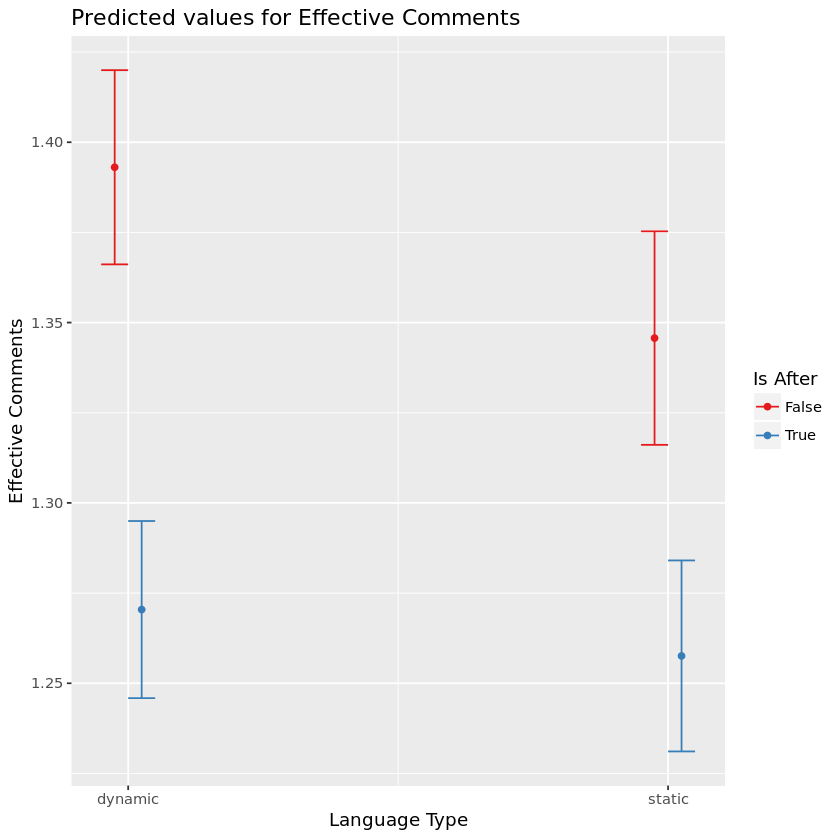

In [65]:
ltypeInteraction <- executeLmOnData(
            EffectiveComments ~ 
            Additions + 
            Deletions +
            IsMerged +
            #Commits + 
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            #TotalReviewComments + 
            TotalReviewCommentThreads +
            GeneralComments + 
            #CommitsAfterCreate + 
            #AdditionsAfterCreate +
            #DeletionsAfterCreate +
            LanguageType *
            IsAfter ,
        sqldf("
            select * from hasEffectiveComments
            where LanguageType != 'unk'
"))

plot_model(ltypeInteraction, type="pred", terms=c('LanguageType', 'IsAfter'))

# Dynamic languages

In [66]:
dynModel <- executeLmOnData(
           EffectiveComments ~ 
            Additions + 
            Deletions +
            IsMerged +
            Commits + 
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            #TotalReviewComments + 
            TotalReviewCommentThreads +
            GeneralComments + 
            #CommitsAfterCreate + 
            #AdditionsAfterCreate +
            #DeletionsAfterCreate +
            IsAfter,
        sqldf("
            select * from hasEffectiveComments
            where LanguageType = 'dynamic'
"))


Call:
lm(formula = formula, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.15549 -0.22814  0.04526  0.26536  2.00015 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    0.0741287  0.0503672   1.472  0.14112    
Additions                      0.0197671  0.0035447   5.576 2.52e-08 ***
Deletions                     -0.0614772  0.0032490 -18.922  < 2e-16 ***
IsMergedTrue                   0.0063535  0.0109765   0.579  0.56272    
Commits                        0.0623807  0.0077112   8.090 6.68e-16 ***
Assignees                     -0.0219142  0.0194808  -1.125  0.26065    
ChangedFiles                   0.0050625  0.0081193   0.624  0.53296    
NumOfUniqueUsers              -0.0208544  0.0179449  -1.162  0.24521    
PRsOpened                     -0.0050470  0.0040353  -1.251  0.21107    
TotalBuilds                    0.0495681  0.0089596   5.532 3.24e-08 ***
NewContributorTrue             0.001

# Static languages

In [67]:
staticModel <- executeLmOnData(
            EffectiveComments ~ 
            Additions + 
            Deletions +
            IsMerged +
            Commits + 
            Assignees + 
            ChangedFiles + 
            NumOfUniqueUsers +
            PRsOpened + 
            TotalBuilds + 
            NewContributor + 
            PrOpenedDaysAfterProjectStart +
            FromOutsider + 
            #TotalReviewComments + 
            TotalReviewCommentThreads +
            GeneralComments + 
            #CommitsAfterCreate + 
            #AdditionsAfterCreate +
            #DeletionsAfterCreate +
            IsAfter,
        sqldf("
            select * from hasEffectiveComments
            where LanguageType = 'static'
"))


Call:
lm(formula = formula, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.3024 -0.2509  0.0429  0.2652  2.0149 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    0.365294   0.066013   5.534 3.26e-08 ***
Additions                      0.021799   0.004637   4.701 2.64e-06 ***
Deletions                     -0.051843   0.004000 -12.959  < 2e-16 ***
IsMergedTrue                   0.010732   0.015426   0.696  0.48662    
Commits                        0.047883   0.008866   5.401 6.87e-08 ***
Assignees                     -0.068502   0.025673  -2.668  0.00765 ** 
ChangedFiles                  -0.001926   0.009793  -0.197  0.84406    
NumOfUniqueUsers              -0.096426   0.021392  -4.508 6.67e-06 ***
PRsOpened                     -0.007787   0.004931  -1.579  0.11431    
TotalBuilds                    0.058060   0.010406   5.579 2.51e-08 ***
NewContributorTrue            -0.046802   0.024053  -1.94